In [9]:
import numpy as np
data = np.load("/home/qianghuang/melady3_work_space/CausalTransformer-main/multirun/2023-08-02/18-31-49/0/train_f.npz")
dict(data).keys()


dict_keys(['cancer_volume', 'chemo_dosage', 'radio_dosage', 'chemo_application', 'radio_application', 'chemo_probabilities', 'radio_probabilities', 'sequence_lengths', 'death_flags', 'recovery_flags', 'patient_types', 'prev_treatments', 'current_treatments', 'current_covariates', 'outputs', 'active_entries', 'unscaled_outputs', 'prev_outputs', 'static_features'])

In [2]:

# covariates: prev_treatments, prev_outputs, vitals, static_features
# treatment: current_treatments
# outcome: outputs
def transform_train_val(data_subset):
    if 'vitals' in data_subset.keys():
        vitals = data_subset['vitals']
    treatments = data_subset['current_treatments']
    outputs = data_subset['outputs']
    # active_entries = data_subset['active_entries']
    sequence_lengths = data_subset['sequence_lengths']

    sample_num, max_length = treatments.shape[0], treatments.shape[1]
    window_size = max_length
    prev_treatments = data_subset['prev_treatments']
    prev_outputs = data_subset['prev_outputs']
    static_features = data_subset['static_features']
    if 'vitals' in data_subset.keys():
        covariates = np.concatenate([vitals, prev_treatments, prev_outputs, static_features[:,np.newaxis,:].repeat(prev_treatments.shape[1], axis=1)], axis=-1)
    else:
        covariates = np.concatenate([prev_treatments, prev_outputs, static_features[:, np.newaxis, :].repeat(prev_treatments.shape[1], axis=1)], axis=-1)
    all_covariates, all_treatments, all_outputs = [], [], []

    for i, seq_len in enumerate(sequence_lengths):
        seq_len = int(seq_len)
        for t in range(seq_len):
            start = max(0, t - window_size + 1)
            pad_step = max(-t + window_size - 1, 0)
            valid_covariates = covariates[i, start:t + 1]
            valid_treatments = treatments[i, start:t + 1]
            valid_outputs = outputs[i, start:t + 1]
            active_entries = np.concatenate([np.zeros((pad_step, 1)), np.ones((valid_covariates.shape[0],1))], axis=0)
            if pad_step > 0:
                valid_covariates = np.concatenate([np.zeros((pad_step, valid_covariates.shape[1])), valid_covariates], axis=0)
                valid_treatments = np.concatenate([np.zeros((pad_step, valid_treatments.shape[1])), valid_treatments], axis=0)
                valid_outputs = np.concatenate([np.zeros((pad_step, valid_outputs.shape[1])), valid_outputs], axis=0)
            valid_covariates = np.concatenate([valid_covariates,active_entries],axis=-1)
            all_covariates.append(valid_covariates)
            all_treatments.append(valid_treatments[-1])
            all_outputs.append(valid_outputs[-1])

    all_covariates = np.stack(all_covariates, axis=0)
    all_treatments = np.stack(all_treatments, axis=0)
    all_outputs = np.stack(all_outputs, axis=0)
    return all_covariates, all_treatments, all_outputs


train_covariates, train_treatments, train_outputs = transform_train_val(data)
# print(train_covariates.shape)
# print(train_treatments.shape)
# print(train_outputs.shape)
# print(train_treatments.mean())
train_treatments.mean()

0.49079774397399556

13.858298290497045 -0.24668544565873415


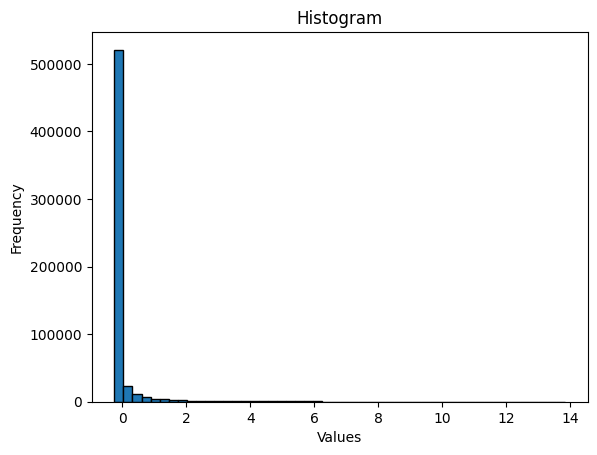

In [3]:
import matplotlib.pyplot as plt

# 示例数据
data =train_outputs
print(train_outputs.max(),train_outputs.min())

plt.hist(data, bins=50, edgecolor='black')

# 添加标题和标签
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# 显示图形
plt.show()

In [4]:
train_treatments.sum(axis=0)

array([288993.])

In [5]:
data_test = np.load("/home/qianghuang/melady3_work_space/CausalTransformer-main/multirun/2023-08-02/18-31-49/0/train_f.npz")

In [6]:

# covariates: prev_treatments, prev_outputs, vitals, static_features
# treatment: current_treatments
# outcome: outputs
def transform_test_cf(data_subset):
    if 'vitals' in data_subset.keys():
        vitals = data_subset['vitals']
    treatments = data_subset['current_treatments']
    outputs = data_subset['outputs']
    # active_entries = data_subset['active_entries']
    sequence_lengths = data_subset['sequence_lengths']

    sample_num, max_length = treatments.shape[0], treatments.shape[1]
    window_size = max_length
    prev_treatments = data_subset['prev_treatments']
    prev_outputs = data_subset['prev_outputs']
    static_features = data_subset['static_features']
    if 'vitals' in data_subset.keys():
        covariates = np.concatenate([vitals, prev_treatments, prev_outputs, static_features[:,np.newaxis,:].repeat(prev_treatments.shape[1], axis=1)], axis=-1)
    else:
        covariates = np.concatenate([prev_treatments, prev_outputs, static_features[:, np.newaxis, :].repeat(prev_treatments.shape[1], axis=1)], axis=-1)
    all_covariates, all_treatments, all_outputs = [], [], []

    for i, seq_len in enumerate(sequence_lengths):
        seq_len = int(seq_len)
        t = int(seq_len) - 1
        start = max(0, t - window_size + 1)
        pad_step = max(-t + window_size - 1, 0)
        valid_covariates = covariates[i, start:t + 1]
        valid_treatments = treatments[i, start:t + 1]
        valid_outputs = outputs[i, start:t + 1]
        active_entries = np.concatenate([np.zeros((pad_step, 1)), np.ones((valid_covariates.shape[0],1))], axis=0)
        if pad_step > 0:
            valid_covariates = np.concatenate([np.zeros((pad_step, valid_covariates.shape[1])), valid_covariates], axis=0)
            valid_treatments = np.concatenate([np.zeros((pad_step, valid_treatments.shape[1])), valid_treatments], axis=0)
            valid_outputs = np.concatenate([np.zeros((pad_step, valid_outputs.shape[1])), valid_outputs], axis=0)
        valid_covariates = np.concatenate([valid_covariates,active_entries],axis=-1)
        all_covariates.append(valid_covariates)
        all_treatments.append(valid_treatments[-1])
        all_outputs.append(valid_outputs[-1])
        print(valid_covariates.shape)

    all_covariates = np.stack(all_covariates, axis=0)
    all_treatments = np.stack(all_treatments, axis=0)
    all_outputs = np.stack(all_outputs, axis=0)
    return all_covariates, all_treatments, all_outputs


test_covariates, test_treatments, test_outputs = transform_test_cf(data_test)
print(test_covariates.shape)
print(test_treatments.shape)
print(test_outputs.shape)



(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)
(59, 4)


In [7]:
print(test_treatments.mean())

0.4989


In [8]:
import pickle
import pandas
file_path = "/home/qianghuang/CausalTransformer-main/multirun/2023-08-02/15-28-15/0/train_scaling_params.pt"
with open(file_path, 'rb') as file:
    data = pickle.load(file)
data


FileNotFoundError: [Errno 2] No such file or directory: '/home/qianghuang/CausalTransformer-main/multirun/2023-08-02/15-28-15/0/train_scaling_params.pt'

In [9]:
import pickle as pkl
train_mean_std = pkl.load(open("/home/qianghuang/melady3_work_space/CausalTransformer-main/multirun/2023-08-02/18-31-49/0/train_scaling_params.pt",'rb'))
train_mean_std[1]['cancer_volume']

numpy.float64